Create correlations between PVs over a 6-month time period. 

Using the EPICS Archiver Appliance as it is about ~10 times faster than my own algorithm. 

In [179]:
import charge_separator as cs
import sys
sys.path.append('/Users/jonathontordilla/Desktop/hombom24/archive-analysis/lcls-tools-plots/archiver_plotter')
import archiver_plotter as ap # type: ignore
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import fclusterdata

In [180]:
"""reference variables"""
charge_pv = "TORO:GUNB:360:CHRG"
ycor_pv = "YCOR:GUNB:293:BACT"
homc1_pv = "SCOP:AMRF:RF01:AI_MEAS1"
aplot = ap.ArchiverPlotter()
csep = cs.ChargeSeparator()

Goal: create DataFrames that contain EPICS Archiver-filtered data over a 6-month period. 

In [181]:
df_charge = pd.read_csv("/Users/jonathontordilla/Desktop/hombom24/archive-analysis/lcls-tools-plots/charge_separated_plots/epics_data/TORO_GUNB_360_CHRG_6M.csv")
df_ycor = pd.read_csv("/Users/jonathontordilla/Desktop/hombom24/archive-analysis/lcls-tools-plots/charge_separated_plots/epics_data/YCOR_GUNB_293_BACT_6M.csv")
df_homc1 = pd.read_csv("/Users/jonathontordilla/Desktop/hombom24/archive-analysis/lcls-tools-plots/charge_separated_plots/epics_data/SCOP_AMRF_RF01_AI_MEAS1_6M.csv")
# Note: cannot create correlations while in this form due to low resolution of data and unlikelihood of matching timestamps. 

Goal: visualize trends over time for the EPICS Archiver-filtered data

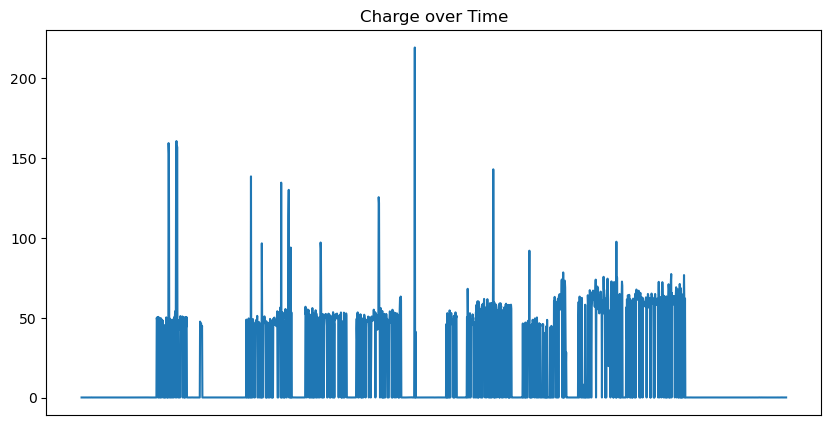

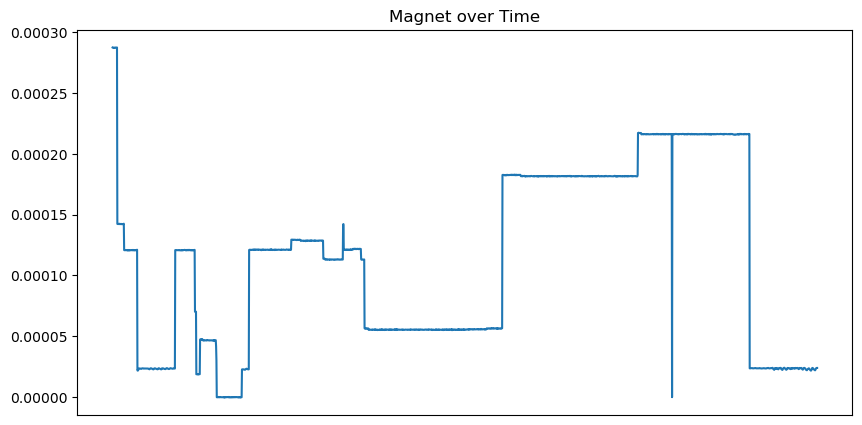

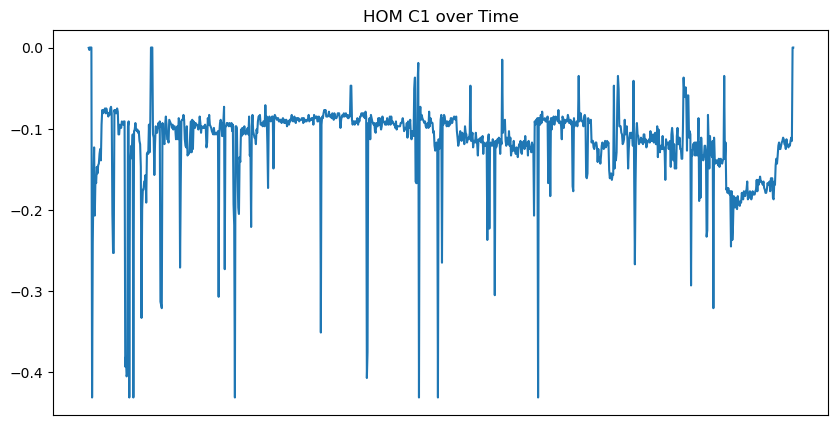

In [182]:
# CHARGE
def plot_charge(): 
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_charge["Timestamp"], df_charge[charge_pv])
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
    ax.set_title("Charge over Time")
    plt.show()
plot_charge()

# MAGNET
def plot_magnet(): 
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_ycor["Timestamp"], df_ycor[ycor_pv])
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
    ax.set_title("Magnet over Time")
    plt.show()
plot_magnet()

# HOM C1
def plot_hom(): 
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_homc1["Timestamp"], df_homc1[homc1_pv])
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
    ax.set_title("HOM C1 over Time")
    plt.show()
plot_hom()

Goal: charge separate with 50% tolerance, remove DataFrames with charges below 15 pC

UPDATE: the following two cells are unnecessary as the same result can be achieved simply by filtering the DataFrame. 

In [183]:
df_charge_list = csep.separate_df_by_charges(df_charge, charge_pv, tolerance=0.5)

def remove_low_charges_list(charges_list: list[pd.DataFrame], pv_charge: str, cutoff_min: float = 15.0) -> list[pd.DataFrame]:
    """Remove DataFrames from the list with charges below a given value.
    
    :param charges_list: List of DataFrames with Timestamp and Charge value columns. 
    :param cutoff_min: Minimum charge value to keep in the list of the DataFrames.
    :param pv_charge: String representation of the charge PV. 
    """
    new_charges_list = []
    for df in charges_list:
        if float(np.mean(df[pv_charge])) > cutoff_min:
            new_charges_list.append(df)
    return new_charges_list

df_charge_list_filtered = remove_low_charges_list(df_charge_list, charge_pv)

Goal: concatenate DataFrames together and sort by Timestamp

In [184]:
df_full_charge_filtered = pd.concat(df_charge_list_filtered)
df_sorted_full_charge_filtered = df_full_charge_filtered.sort_values(by=["Timestamp"])

Goal: merge with the other PVs by Timestamp, within some margin of error

In [185]:
def merge_with_margin_on_timestamp(df_1: pd.DataFrame, df_2: pd.DataFrame, time_margin_seconds: float): 
    """Merges two DataFrames on similar timestamps, where timestamps differ by less than the time specified by the time_margin parameter.
    
    Creates additional columns that store the time difference between the true and comparison timestamps. 
    
    :param df_1: First DataFrame with a Timestamp column.
    :param df_2: Second DataFrame with a Timestamp column.
    :param time_margin_seconds: The time margin between two timestamps as given in seconds, useful for defining the propagated error for a correlation.
    """
    
    # Must convert the values in the Timestamp column to datetime objects
    df_1["Timestamp"] = pd.to_datetime(df_1["Timestamp"])
    df_2["Timestamp"] = pd.to_datetime(df_2["Timestamp"])
    
    """Use the pandas method merge_asof to merge the DataFrames within a tolerance value (pandas.pydata.org/docs/reference/api/pandas.merge_asof.html). 
    According to the pd.merge_asof() function, the first DataFrame parameter in the function defines what the second DataFrame is compared to. 
    Therefore, the first DataFrame will have a time-axis uncertainty of 0. 
    The second DataFrame will have some uncertainty ranging from 0 to the time_margin_seconds value. 
    """
    
    # compute the time difference between the second and first DataFrames and add a new column to the second DataFrame
    df_merged = pd.merge_asof(df_1, df_2, on="Timestamp", direction="nearest", tolerance=pd.Timedelta(f"{time_margin_seconds}s"))
    df_merged[f"{df_2.columns[1]} Time Uncert"] = df_merged[df_2.columns[1]] - df_merged[df_1.columns[1]]  # get time uncertainty
    
    # Convert values in the Timestamp column back to String objects, remove NaN rows, and return 
    timestamp_list = df_merged["Timestamp"].to_list()
    df_merged["Timestamp"] = timestamp_list
    return df_merged.dropna(how="any")

df_charge_ycor = merge_with_margin_on_timestamp(df_sorted_full_charge_filtered, df_ycor, time_margin_seconds=10)
df_correl = merge_with_margin_on_timestamp(df_charge_ycor, df_homc1, time_margin_seconds=10)
df_correl

,Timestamp,TORO:GUNB:360:CHRG,YCOR:GUNB:293:BACT,YCOR:GUNB:293:BACT Time Uncert,SCOP:AMRF:RF01:AI_MEAS1,SCOP:AMRF:RF01:AI_MEAS1 Time Uncert
0,2024-02-19 11:59:59.217,49.905624,0.000121,-49.905503,-0.430992,-50.336617
1,2024-02-19 13:59:55.317,48.373100,0.000070,-48.373030,-0.241000,-48.614100
2,2024-02-19 15:59:56.417,50.232349,0.000070,-50.232279,-0.171000,-50.403349
3,2024-02-19 21:59:59.517,50.473831,0.000019,-50.473812,-0.161000,-50.634831
4,2024-02-19 23:59:55.632,48.728348,0.000019,-48.728329,-0.167000,-48.895348
...,...,...,...,...,...,...
688,2024-07-02 04:59:59.097,65.796349,0.000216,-65.796133,-0.121000,-65.917349
689,2024-07-02 06:59:53.379,67.719551,0.000216,-67.719335,-0.121000,-67.840551
690,2024-07-02 08:59:56.179,62.620598,0.000216,-62.620382,-0.123000,-62.743598
691,2024-07-02 12:59:50.679,63.332169,0.000216,-63.331953,-0.121000,-63.453169


Goal: for a specific charge value, plot the correlation between the HOM C1 Signal and another PV

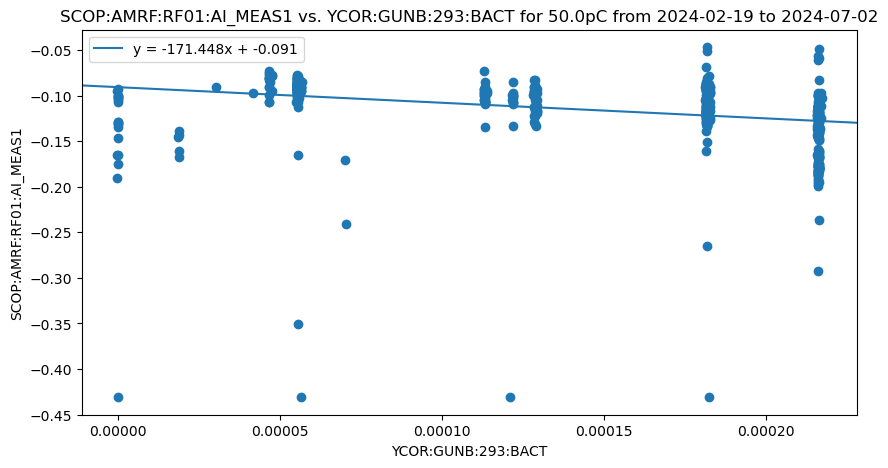

In [186]:
def plot_correlation(df: pd.DataFrame, pv_y: str, pv_x: str, pv_charge: str, charge_val: float, charge_tolerance: float): 
    """Plots the correlation between two columns in a DataFrame, separated by a specific charge value (pC). 
    
    The DataFrame will be modified to only include rows that contain a charge value within a given tolerance percentage range (0.0-1.0). 
    
    :param df: DataFrame with a Timestamp column and an arbitrary amount of PV columns.
    :param pv_y: String representation of the PV to be plotted on the y-axis.
    :param pv_x: String representation of the PV to be plotted on the x-axis.
    :param pv_charge: String representation of the charge PV by which to filter the DataFrame.
    :param charge_val: The charge value in pC by which to separate out rows. 
    :param charge_tolerance: The percentage tolerance between 0.0-1.0 (inclusive) to inform how large of a spread of charge values are kept in the DataFrame. 
    """
    
    # filter out unwanted charges
    df_charge_filtered = df[(df[pv_charge] >= charge_val - (charge_val * charge_tolerance)) & (df[pv_charge] <= charge_val + (charge_val * charge_tolerance))]
    fig, ax = plt.subplots(figsize=(10, 5))
    # plot correlation points
    x = df_charge_filtered[pv_x]
    y = df_charge_filtered[pv_y]
    ax.scatter(x, y) 
    
    # create a line of best fit
    slope, intercept = np.polyfit(x, y, deg=1)  
    ax.axline(xy1=(0, intercept), slope=slope, label=f"y = {slope:.3f}x + {intercept:.3f}")
    
    # set labels
    start_date = str(df_charge_filtered["Timestamp"].to_list()[0])[:10]
    end_date = str(df_charge_filtered["Timestamp"].to_list()[-1])[:10]
    ax.set_title(f"{pv_y} vs. {pv_x} for {charge_val}pC from {start_date} to {end_date}")
    ax.set_xlabel(pv_x)
    ax.set_ylabel(pv_y)
    ax.legend()
    plt.show()

# For Q ~ 50 pC, plot the correlation between HOM C1 vs. YCOR
plot_correlation(df_correl, pv_y="SCOP:AMRF:RF01:AI_MEAS1", pv_x="YCOR:GUNB:293:BACT", pv_charge="TORO:GUNB:360:CHRG", charge_val=50.0, charge_tolerance=0.5)

Goal: cluster data and get mean and std of y point

In [187]:
def create_clusters(df: pd.DataFrame, low_vary_column: str, error_tolerance: float) -> list[pd.DataFrame]: 
    """Create a list of DataFrames, each with data points with similar x values but varying y values.
    
    :param df: DataFrame with at least and x_column and a y_column from which to create clusters. 
    :param low_vary_column: String of the title of the column with points by which to create clusters.
    :param error_tolerance: The tolerance range of the x values in whatever units the x_column is. 
    """
    
    df = df.sort_values(by=low_vary_column).reset_index(drop=True)
    
    # group the values by similar x values
    df_groups: list[pd.DataFrame] = []
    curr_group: list[pd.Series] = []
    
    for i, curr_row in df.iterrows(): 
        if not curr_group: 
            curr_group.append(curr_row)  # add current row to the group if no rows added yet
        else: 
            # if the row is not empty, check if the item in the cell in the x_column of the current row in within range
            if abs(curr_group[-1][low_vary_column] - curr_row[low_vary_column]) <= error_tolerance: 
                curr_group.append(curr_row)
            else: 
                # if it is out of range, add the current group as a DataFrame to the list
                df_groups.append(pd.DataFrame(curr_group))
                curr_group = [curr_row]  # create a new group with the new row
    
    # handle remaining rows and add to a DataFrame and then to the DataFrame list
    if curr_group: 
        df_groups.append(pd.DataFrame(curr_group))
        
    return df_groups
    
df_group_list = create_clusters(df_correl, "YCOR:GUNB:293:BACT", 0.000015)
print(f"{len(df_group_list)} groups created")

5 groups created


In [192]:
def get_means_and_stds(df_groups: list[pd.DataFrame], high_vary_column: str) -> list[tuple[float, float]]:
    """Create a 2D list with means and standard deviations for each cluster.
    
    Returns a list of pairs (mean of each cluster, std for each cluster). 
    
    :param df_groups: List of DataFrames, each one representing a different cluster. 
    :param high_vary_column: String of the title of the column with the varying points in a cluster. 
    """
    
    result = []
    for group_index in range(len(df_groups)):
        mean = float(np.mean(df_groups[group_index][high_vary_column]))
        curr_std = float(np.std(df_groups[group_index][high_vary_column]))
        result.append((mean, curr_std))
    return result

get_means_and_stds(df_group_list, "SCOP:AMRF:RF01:AI_MEAS1")

[(-0.14189961, 0.07211355285166514),
 (-0.10611225775401069, 0.06182965963262873),
 (-0.11483149684210531, 0.050423091315909184),
 (-0.11142419515151515, 0.03649435968948063),
 (-0.14034831460674158, 0.0348966696597143)]

Goal: plot error bars

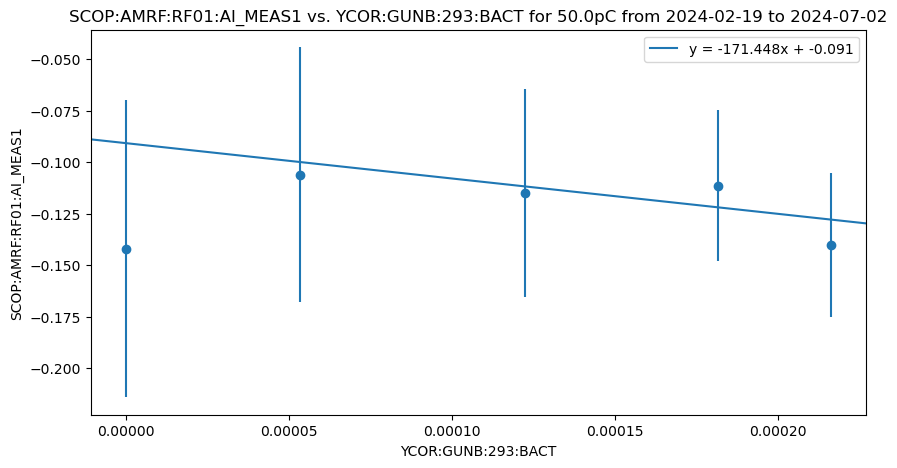

In [207]:
def plot_correlation_error(df: pd.DataFrame, pv_y: str, pv_x: str, pv_charge: str, charge_val: float, charge_tolerance: float, 
                           low_vary_column: str, high_vary_column: str, error_tolerance: float, y_vary=True):
    """Plots the correlation between two columns in a DataFrame, separated by a specific charge value (pC). 
    
    The DataFrame will be modified to only include rows that contain a charge value within a given tolerance percentage range (0.0-1.0). 
    
    :param df: DataFrame with a Timestamp column and an arbitrary amount of PV columns.
    :param pv_y: String representation of the PV to be plotted on the y-axis.
    :param pv_x: String representation of the PV to be plotted on the x-axis.
    :param pv_charge: String representation of the charge PV by which to filter the DataFrame.
    :param charge_val: The charge value in pC by which to separate out rows. 
    :param charge_tolerance: The percentage tolerance between 0.0-1.0 (inclusive) to inform how large of a spread of charge values are kept in the DataFrame. 
    :param low_vary_column: String of the title of the column with points by which to create clusters.
    :param high_vary_column: String of the title of the column with the varying points in a cluster. 
    :param error_tolerance: The tolerance range of the x values in whatever units the x_column is. 
    :param y_vary: Boolean indicating if the y_column is varying or not.
    """
    
    # filter out unwanted charges
    df_charge_filtered = df[(df[pv_charge] >= charge_val - (charge_val * charge_tolerance)) & (df[pv_charge] <= charge_val + (charge_val * charge_tolerance))]
    fig, ax = plt.subplots(figsize=(10, 5))
    # get correlation points
    x = df_charge_filtered[pv_x]
    y = df_charge_filtered[pv_y]
    
    # create a line of best fit
    slope, intercept = np.polyfit(x, y, deg=1)  
    ax.axline(xy1=(0, intercept), slope=slope, label=f"y = {slope:.3f}x + {intercept:.3f}")
    
    # plot cluster points
    df_groups: list[pd.DataFrame] = create_clusters(df_correl, low_vary_column, error_tolerance)
    means_and_stds: list[(float, float)] = get_means_and_stds(df_groups, "SCOP:AMRF:RF01:AI_MEAS1")
    
    y_cluster_points = []
    x_cluster_points = []
    if y_vary:  # if the points in the y_column are the varying points in a cluster
        y_cluster_points = [cluster[0] for cluster in means_and_stds]  # average y val in each cluster
        x_cluster_points = [float(np.mean(df_groups[df][pv_x])) for df in range(len(df_groups))]  # average x val in each cluster
    else: 
        y_cluster_points = [float(np.mean(df_groups[df][pv_y])) for df in range(len(df_groups))]  # average y val in each cluster
        x_cluster_points = [cluster[0] for cluster in means_and_stds]  # average x val in each cluster
        
    ax.scatter(x_cluster_points, y_cluster_points)
        
    # plot error bars
    error = [cluster[1] for cluster in means_and_stds]
    ax.errorbar(x_cluster_points, y_cluster_points, yerr=error, ls="none")
    
    # set labels
    start_date = str(df_charge_filtered["Timestamp"].to_list()[0])[:10]
    end_date = str(df_charge_filtered["Timestamp"].to_list()[-1])[:10]
    ax.set_title(f"{pv_y} vs. {pv_x} for {charge_val}pC from {start_date} to {end_date}")
    ax.set_xlabel(pv_x)
    ax.set_ylabel(pv_y)
    ax.legend()
    plt.show()

# For Q ~ 50 pC, plot the correlation between HOM C1 vs. YCOR
plot_correlation_error(df_correl, pv_y="SCOP:AMRF:RF01:AI_MEAS1", pv_x="YCOR:GUNB:293:BACT", pv_charge="TORO:GUNB:360:CHRG", charge_val=50.0, charge_tolerance=0.5, 
                       low_vary_column="YCOR:GUNB:293:BACT", high_vary_column="SCOP:AMRF:RF01:AI_MEAS1", error_tolerance=0.000015)

Goal: plot box and whisker (NOTE: will only use if specifically asked for, leave in this functional format with overly-specified parameters with unresolved TODOs)

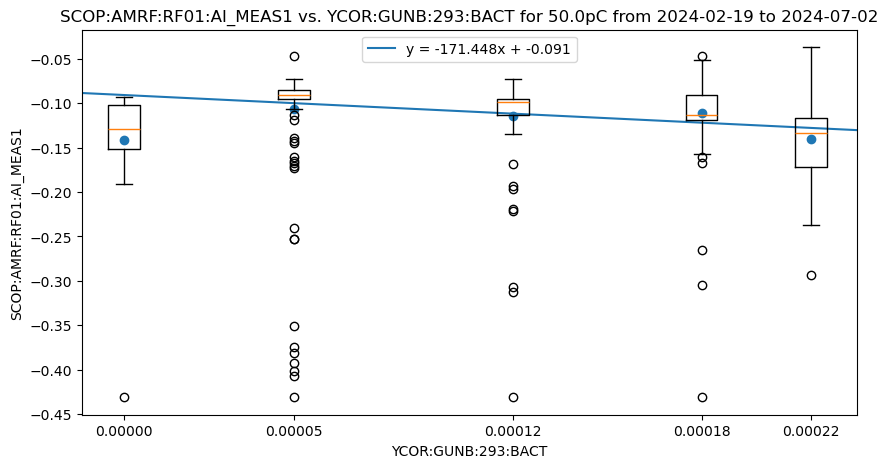

In [249]:
from matplotlib.ticker import FormatStrFormatter


def plot_correlation_error(df: pd.DataFrame, pv_y: str, pv_x: str, pv_charge: str, charge_val: float, charge_tolerance: float, 
                           low_vary_column: str, high_vary_column: str, error_tolerance: float, y_vary=True):
    """Plots the correlation between two columns in a DataFrame, separated by a specific charge value (pC). 
    
    The DataFrame will be modified to only include rows that contain a charge value within a given tolerance percentage range (0.0-1.0). 
    
    :param df: DataFrame with a Timestamp column and an arbitrary amount of PV columns.
    :param pv_y: String representation of the PV to be plotted on the y-axis.
    :param pv_x: String representation of the PV to be plotted on the x-axis.
    :param pv_charge: String representation of the charge PV by which to filter the DataFrame.
    :param charge_val: The charge value in pC by which to separate out rows. 
    :param charge_tolerance: The percentage tolerance between 0.0-1.0 (inclusive) to inform how large of a spread of charge values are kept in the DataFrame. 
    :param low_vary_column: String of the title of the column with points by which to create clusters.
    :param high_vary_column: String of the title of the column with the varying points in a cluster. 
    :param error_tolerance: The tolerance range of the x values in whatever units the x_column is. 
    :param y_vary: Boolean indicating if the y_column is varying or not.
    """
    
    # filter out unwanted charges
    df_charge_filtered = df[(df[pv_charge] >= charge_val - (charge_val * charge_tolerance)) & (df[pv_charge] <= charge_val + (charge_val * charge_tolerance))]
    fig, ax = plt.subplots(figsize=(10, 5))
    # get correlation points
    x = df_charge_filtered[pv_x]
    y = df_charge_filtered[pv_y]
    
    # create a line of best fit
    slope, intercept = np.polyfit(x, y, deg=1)  
    ax.axline(xy1=(0, intercept), slope=slope, label=f"y = {slope:.3f}x + {intercept:.3f}")
    
    # plot cluster points
    df_groups: list[pd.DataFrame] = create_clusters(df_correl, low_vary_column, error_tolerance)
    means_and_stds: list[(float, float)] = get_means_and_stds(df_groups, "SCOP:AMRF:RF01:AI_MEAS1")
    y_cluster_points = []
    x_cluster_points = []
    if y_vary:  # if the points in the y_column are the varying points in a cluster
        y_cluster_points = [cluster[0] for cluster in means_and_stds]  # average y val in each cluster
        x_cluster_points = [float(np.mean(df_groups[df][pv_x])) for df in range(len(df_groups))]  # average x val in each cluster
    else: 
        y_cluster_points = [float(np.mean(df_groups[df][pv_y])) for df in range(len(df_groups))]  # average y val in each cluster
        x_cluster_points = [cluster[0] for cluster in means_and_stds]  # average x val in each cluster
    ax.scatter(x_cluster_points, y_cluster_points)
        
    # plot box and whisker
    data_vary = [df_groups[df_index][high_vary_column].to_list() for df_index in range(len(df_groups))]
    ax.boxplot(data_vary, positions=x_cluster_points, widths=0.00001)  # TODO: set widths depending on the varying column
    
    # set labels
    start_date = str(df_charge_filtered["Timestamp"].to_list()[0])[:10]
    end_date = str(df_charge_filtered["Timestamp"].to_list()[-1])[:10]
    ax.set_title(f"{pv_y} vs. {pv_x} for {charge_val}pC from {start_date} to {end_date}")
    ax.set_xlabel(pv_x)
    ax.set_ylabel(pv_y)
    ax.set_xlim(x_cluster_points[0] - x_cluster_points[0] * 1000, x_cluster_points[-1] + x_cluster_points[-1] / 15)  # TODO: not sure how to set these parameters
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.5f'))  # TODO: still need to round up to relevant units for paper plots
    ax.legend()
    plt.show()

# For Q ~ 50 pC, plot the correlation between HOM C1 vs. YCOR
plot_correlation_error(df_correl, pv_y="SCOP:AMRF:RF01:AI_MEAS1", pv_x="YCOR:GUNB:293:BACT", pv_charge="TORO:GUNB:360:CHRG", charge_val=50.0, charge_tolerance=0.5, 
                       low_vary_column="YCOR:GUNB:293:BACT", high_vary_column="SCOP:AMRF:RF01:AI_MEAS1", error_tolerance=0.000015)

Process: 
1. Create DataFrames for all PVs of interest over a 6-month timeframe: `df_pv = pd.read_csv()`
2. Remove charges less than a given value, like 15 pC: `df_charge = df_charge[df_charge[pv_charge] >= cutoff]`
3. Merge all DataFrames together, by Timestamp, given a margin of error:
```
df_charge_ycor = merge_with_margin_on_timestamp(df_charge, df_ycor, time_margin_seconds=10)
df_correl = merge_with_margin_on_timestamp(df_charge_ycor, df_homc1, time_margin_seconds=10)
```
4. Plot the correlation, given a values for what is on the y and x axes, units, the charge value by which to separate, and the tolerance of this value. 
```
# For Q ~ 50 pC, plot the correlation between HOM C1 vs. YCOR
plot_correlation(df_correl, pv_y="SCOP:AMRF:RF01:AI_MEAS1", pv_x="YCOR:GUNB:293:BACT", pv_charge="TORO:GUNB:360:CHRG", charge_val=50.0, charge_tolerance=0.5)
```